# Next 3 minutes (approx.) of your presentation -- Core Analysis
If you used ML (regression, classification, or something else); mention mainly WHICH one(s).
You may now briefly CLARIFY why and how the ML problem(s) aim(s) to solve your objective.
How did you apply ML technique(s) to SOLVE your problem? Which model(s), how and why?
Did you only use tools and techniques learned in this course? What ELSE did you learn / try?

#### Import libriaries and framework

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#### Prepare the data

In [4]:
# Load the data from the CSV file into a DataFrame
data = pd.read_csv('datasets/listings_preprocessed.csv')

# Separate the input features (X) and target variable (y)
X = data.drop('price', axis=1)
y = data['price']

# Filter out non-numeric columns
numeric_columns = X.select_dtypes(include=['number']).columns
X_numeric = X[numeric_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align the columns of the training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Fill missing values in the training set with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)

# Fill missing values in the test set with the mean of the corresponding columns in the training set
X_test.fillna(X_train.mean(), inplace=True)

# Fill remaining NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

#### Filter and extract only top 5 variables to be used to predict the price

In [6]:
# Calculate the correlation matrix between features and the target variable
corr_matrix = X_train.corrwith(y_train)

# Compute the absolute correlation values
abs_corr_matrix = corr_matrix.abs()

# Select the top 5 variables with the highest absolute correlation values
top_5_abs_correlated = abs_corr_matrix.sort_values(ascending=False)[:5]

# Print the top 5 variables
print("Top 5 variables with the highest absolute correlation values:\n", top_5_abs_correlated)

# Filter the original training and testing sets to include only the top 5 variables with the highest absolute correlation values
X_train_selected = X_train[top_5_abs_correlated.index]
X_test_selected = X_test[top_5_abs_correlated.index]

Top 5 variables with the highest absolute correlation values:
 room_type_Private room                         0.442091
bedrooms                                       0.425693
calculated_host_listings_count_entire_homes    0.410485
property_type_Private room in rental unit      0.400065
minimum_nights                                 0.389756
dtype: float64


#### Create the model and predict the data

In [7]:
# Create a linear regression model
model = LinearRegression()

# Train the model using the training data with the selected features
model.fit(X_train_selected, y_train)

# Predict the prices for the test set
y_pred = model.predict(X_test_selected)

#### Display the coefficients and performance metrics

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the mean squared error and R^2 score for the predictions
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients of the linear regression model
coefficients = model.coef_
print("Linear regression model coefficients")
for feature, coef in zip(top_5_abs_correlated.index, coefficients):
    print(f"{feature}: {coef}")

# Print the results
print("")
print("Performance metrics")
print("Mean squared error:", mse)
print("R^2 score:", r2)


Linear regression model coefficients
room_type_Private room: -19.484279206013074
bedrooms: 73.40273234288092
calculated_host_listings_count_entire_homes: 0.4705023673372429
property_type_Private room in rental unit: -35.843745504030956
minimum_nights: -0.9864976125499291

Performance metrics
Mean squared error: 8543.043268167366
R^2 score: 0.4817814287276203


#### Plot the regression model

#### Linear regression model for each variable predicting the price individually

###### loop through the top 20 positively correlated features

In [10]:
# Initialize lists to store R^2 scores and coefficients
r2_scores = []
coefficients = []

# Loop through the top 20 positively correlated features
for feature in top_5_abs_correlated.index:
    # Create a linear regression model
    model = LinearRegression()

    # Train the model using the individual feature from the training data
    model.fit(X_train_selected[[feature]], y_train)

    # Predict the prices for the test set
    y_pred = model.predict(X_test_selected[[feature]])

    # Calculate the R^2 score for the predictions
    r2 = r2_score(y_test, y_pred)

    # Append the R^2 score and coefficient to the respective lists
    r2_scores.append(r2)
    coefficients.append(model.coef_[0])

# Print the R^2 scores and coefficients for each feature
for feature, r2, coef in zip(top_5_abs_correlated, r2_scores, coefficients):
    print(f"{feature}: R^2 = {r2:.4f}, Coefficient = {coef:.4f}")


0.4420911016284186: R^2 = 0.2129, Coefficient = -106.5430
0.42569278999593996: R^2 = 0.2281, Coefficient = 90.1501
0.41048452219713794: R^2 = 0.1909, Coefficient = 0.7649
0.40006513672477356: R^2 = 0.1546, Coefficient = -118.4313
0.389756167687764: R^2 = 0.1155, Coefficient = -1.0541


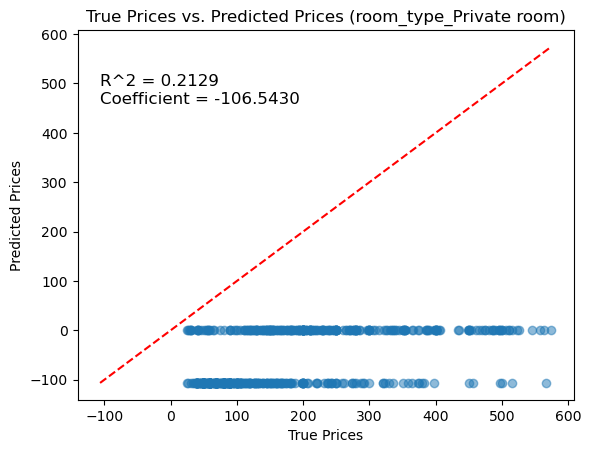

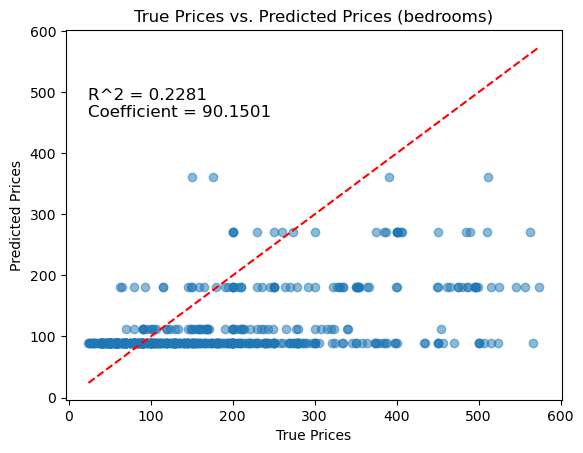

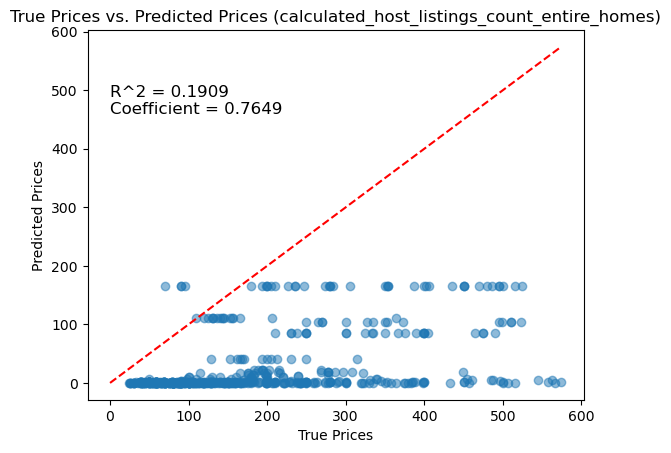

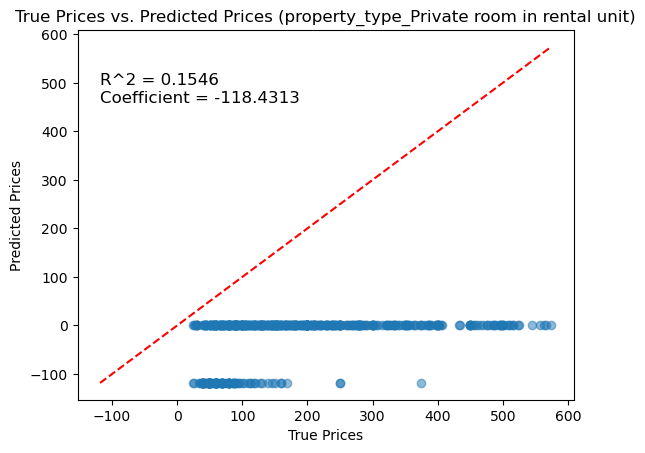

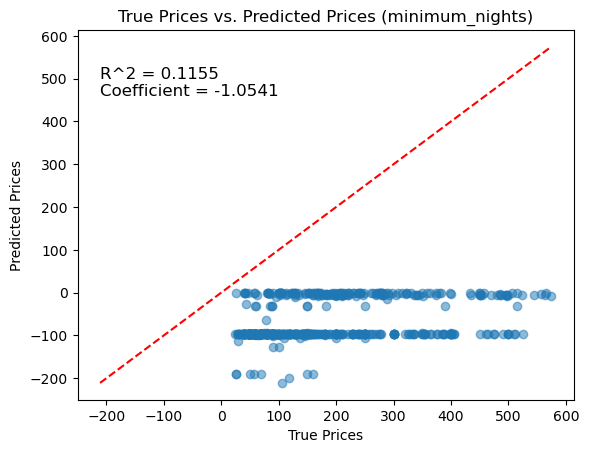

In [13]:
# Function to create a scatter plot for each feature
def plot_regression(feature, y_test, y_pred, r2, coef):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'True Prices vs. Predicted Prices ({feature})')

    min_val = min(y_test.min(), y_pred.min()[0])
    max_val = max(y_test.max(), y_pred.max()[0])
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    plt.text(min_val, max_val * 0.8, f'R^2 = {r2:.4f}\nCoefficient = {coef:.4f}', fontsize=12)
    plt.show()

# Loop through the top 20 positively correlated features and create a plot for each
for feature, r2, coef in zip(top_5_abs_correlated.index, r2_scores, coefficients):
    y_pred = X_test_selected[[feature]] * coef
    plot_regression(feature, y_test, y_pred, r2, coef)

#### Visualize the performance of the regression model

##### Create a scatter plot of the true prices (y_test) against the predicted prices (y_pred)

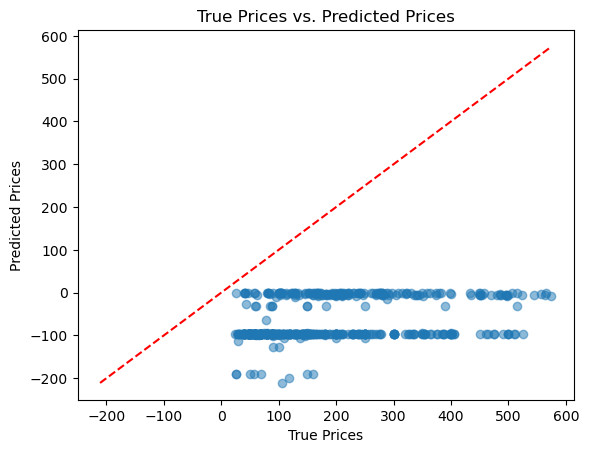

In [17]:
import numpy as np

# Create a scatter plot of the true prices against the predicted prices
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('True Prices vs. Predicted Prices')

# Convert y_test and y_pred to NumPy arrays
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

# Add a diagonal line to represent perfect predictions
min_val = min(y_test_np.min(), y_pred_np.min())
max_val = max(y_test_np.max(), y_pred_np.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Show the plot
plt.show()

##### General comment

##### It seems to be that using linear regression to predict the data is more straightforward by looking at the model. We are able to deduce that most of the variables are indeed not able to predict the price since its correlation value is less than 0.5